# **Dataset Creation**

In [1]:
!pip install pyspark==3.5.0 delta-spark==3.1.0

from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (
SparkSession.builder.appName("DeltaDemo")
.config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
.config("spark.sql.catalog.spark_catalog",
"org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

data = [
(1, "John", "Electronics", 2, 300),
(2, "Sara", "Clothing", 1, 50),
(3, "Mike", "Electronics", 4, 600),
(4, "Nina", "Clothing", 3, 150),
]

columns = ["order_id", "customer_name", "category", "quantity", "amount"]

df = spark.createDataFrame(data, columns)

df.write.format("delta").mode("overwrite").save("/content/orders_delta")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=113b1265c507b04f94a2c0a37ee2b6ce593284f6630f9c2499bbcd661d993dc0
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [2]:
df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



# **1. Managed vs Unmanaged Tables**
**Task:**

Create a managed table orders_managed from /tmp/orders_delta

Create an unmanaged table orders_unmanaged pointing to the same location

In [3]:
spark.sql("DROP TABLE IF EXISTS orders_managed")
spark.sql("DROP TABLE IF EXISTS orders_unmanaged")

spark.sql("CREATE TABLE orders_managed USING DELTA LOCATION '/content/orders_delta'")
spark.sql("CREATE TABLE orders_unmanaged USING DELTA LOCATION '/content/orders_delta'")

print("Tables created:")
spark.sql("SHOW TABLES").show()

Tables created:
+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|  default|  orders_managed|      false|
|  default|orders_unmanaged|      false|
+---------+----------------+-----------+



# **2. CRUD Operations**
**Task:**

-Read from the table

-Update all "Clothing" category orders to have amount = amount + 20

-Delete all orders with quantity < 2

-Merge in a new dataset (new orders & updated orders)

In [5]:
orders_df = spark.read.format("delta").load("/content/orders_delta")
orders_df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [6]:
from pyspark.sql import functions as F

orders_df = orders_df.withColumn(
    "amount",
    F.when(F.col("category") == "Clothing", F.col("amount") + 20).otherwise(F.col("amount"))
)
orders_df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



In [7]:
orders_df = orders_df.filter(F.col("quantity") >= 2)
orders_df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
+--------+-------------+-----------+--------+------+



In [8]:
new_data = [
    (3, "Mike", "Electronics", 5, 750),
    (5, "Alex", "Furniture", 1, 200),
]
new_df = spark.createDataFrame(new_data, columns)

from delta.tables import DeltaTable
delta_table = DeltaTable.forPath(spark, "/content/orders_delta")

delta_table.alias("target").merge(
    new_df.alias("source"),
    "target.order_id = source.order_id"
).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

print("After CRUD operations:")
delta_table.toDF().show()

After CRUD operations:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   150|
|       5|         Alex|  Furniture|       1|   200|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



# **3. History & Time Travel**
**Task:**

-Use DESCRIBE HISTORY to check previous versions

-Read data from version 0 and compare with the latest version

In [9]:
print("History:")
delta_table.history().show()

print("Version 0:")
spark.read.format("delta").option("versionAsOf", 0).load("/content/orders_delta").show()

History:
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      1|2025-08-14 05:43:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          0|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      0|2025-08-14 05:31:...|  NULL|    NULL|    WRITE|{mode -> Overwrit...|NULL|    NULL|     NULL|       NULL|  Serializable|        false|{numFiles -> 2, n...|        NULL|Apache-Spark/3.5....|
+

# **4. Incremental Load Pattern**
**Task:**

-Create a new mini-batch with only new orders (IDs 5 & 6)

-Append to the Delta table

-Show final result

In [10]:
batch_df = spark.createDataFrame([
    (6, "Emma", "Clothing", 2, 100),
    (7, "Liam", "Electronics", 1, 400)
], columns)

batch_df.write.format("delta").mode("append").save("/content/orders_delta")

print("After incremental load:")
spark.read.format("delta").load("/content/orders_delta").show()

After incremental load:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   150|
|       5|         Alex|  Furniture|       1|   200|
|       7|         Liam|Electronics|       1|   400|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       6|         Emma|   Clothing|       2|   100|
+--------+-------------+-----------+--------+------+



# **5. Simple Streaming Read**
**Task:**

-Read the /tmp/orders_delta in streaming mode

-Output to console every 5 seconds

In [13]:
streaming_df = (
    spark.readStream.format("delta")
    .load("/content/orders_delta")
)

query = (
    streaming_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)

import time
time.sleep(15)
query.stop()

# **6. Visualization**
**Task:**

-Read Delta table into Pandas

-Create a bar chart of category vs total amount

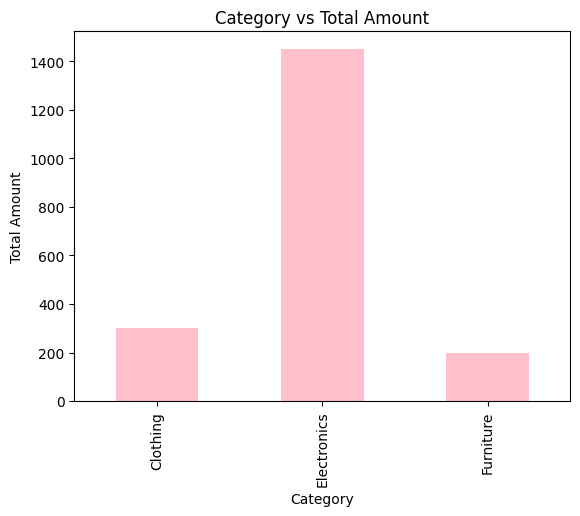

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = spark.read.format("delta").load("/content/orders_delta").toPandas()
category_amount = pdf.groupby("category")["amount"].sum()

category_amount.plot(kind="bar", color="pink")
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()